# Graph Convolutional Networksによるノード分類

---



# ノード分類　


---




今回から, グラフ構造を畳み込んでいきます．  

ここでは"ノード分類"というタスクを行います.  
ノード分類とは, グラフのノードがどのクラスに属しているかを分類するタスクです. 

グラフを入力とする畳み込みニューラルネットワークである, Graph Convolutional Networks(GCN)を使って，ノード分類をしてみます. 

必要なモジュールをインストールします.

In [1]:
pip install dgl \
pip install networkx

     |████████████████████████████████| 3.6MB 5.4MB/s 


インポートしておきます.

In [2]:
import dgl
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


#karate club データセット

---



ノード分類のためのデータセットを準備します．  今回はkarate clubデータセットを使います.  
ダウンロードもできますが，非常に小さなグラフなので，手作業で定義します．

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


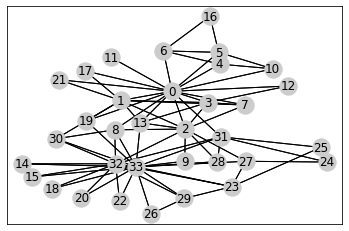

In [3]:
def karate_club_graph():
    g = dgl.DGLGraph()
    g.add_nodes(34) #ノードを34個用意
    # 78本のエッジを定義 
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    roop_list = []
    for i in range(34):
      roop_list.append((i, i))
    # 無向グラフへ変換
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    src, dst = tuple(zip(*roop_list))
    g.add_edges(src, dst)

    return g

G = karate_club_graph()
# 描画
nx_G = G.to_networkx()
pos = nx.kamada_kawai_layout(nx_G) # 後々分かりやすくする為,ノードの位置を固定します.
nx.draw_networkx(nx_G, pos=pos, arrows=False, node_color=[0.8, 0.8, 0.8])
plt.show()

- karate club データセット  
karate clubデータセットは, ある大学の空手クラブの人間関係を表現したソーシャルネットワークグラフです.  
34個(0~33)のノードは人間を表現しています.  
ノード0はインストラクター，ノード33はクラブ会長です.その他のノードは空手クラブに所属する学生です.  
78本のエッジは，空手クラブ外での交友関係により定義されました.  

この空手クラブは，インストラクターと会長との仲が悪く，学生がインストラクター派閥，会長派閥に別れることになりました．  
グラフの接続関係から，インストラクター派閥クラスなのか,会長派閥クラスなのかの２クラス分類を試みます.

また，ノード分類は半教師あり学習です． インストラクターと会長だけ事前にクラスがわかっています.   
インストラクター派閥を0クラス, 会長派閥を1クラスとします.

# Graph Convolution

---


グラフから特徴を抽出する為, グラフを畳み込みます.  
Deep Graph Libraryによって簡単にグラフ畳み込みを扱うことができますが，ここでは自分で定義してみます.


Graph convolution([Kipf & Welling, ICLR2017](https://arxiv.org/pdf/1609.02907.pdf))の数式は以下の通りです.

\begin{equation}
{\bf H}^{(l+1)}=\sigma({\bf\tilde D}^{-\frac{1}{2}}{\bf\tilde A}{\bf\tilde D}^{-\frac{1}{2}}{\bf H}^{(l)}{\bf W}^{(l)})
\end{equation}


${\bf A}\in{\mathbb R}^{N\times N}$が隣接行列です($N$：ノード数).  
隣接行列の前後に次数行列${\bf\tilde D}$がある理由は難しいため割愛します． 正規化だと思っていれば大丈夫です.  
${\bf\tilde D}^{-\frac{1}{2}}{\bf\tilde A}{\bf\tilde D}^{-\frac{1}{2}}$でグラフの接続関係を示します.

${\bf H}\in{\mathbb R}^{(N\times C)}$は特徴($C$:入力の次元数),  ${\bf W}\in{\mathbb R}^{(C\times F)}$は重み行列($F$:出力の次元数)です. $\sigma(\cdot)$は活性化関数です.

Graph Convolutionは
- グラフの接続関係  (${\bf\tilde D}^{-\frac{1}{2}}{\bf\tilde A}{\bf\tilde D}^{-\frac{1}{2}}$)
- 入力  (${\bf H}\in{\mathbb R}^{(N\times C)}$)
- 重み行列  (${\bf W}\in{\mathbb R}^{(C\times F)}$)  

の3つの行列で簡単に実装することができます.

隣接行列は, 学習中に変化することはありません.  
Graph Convolution関数の中ではなく, 事前に定義しておきます.


In [4]:
# DGL Graphから隣接行列を作成
adj = G.adjacency_matrix().to_dense().numpy()

# A -> DADの変換です.
def normalize_undigraph(A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-0.5)
    DAD = np.dot(np.dot(Dn, A), Dn)
    return DAD

print(adj)
adj = normalize_undigraph(adj)
adj = torch.Tensor(adj)
print(adj)

[[1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
tensor([[0.0588, 0.0767, 0.0731,  ..., 0.0917, 0.0000, 0.0000],
        [0.0767, 0.1000, 0.0953,  ..., 0.0000, 0.0000, 0.0000],
        [0.0731, 0.0953, 0.0909,  ..., 0.0000, 0.0836, 0.0000],
        ...,
        [0.0917, 0.0000, 0.0000,  ..., 0.1429, 0.1048, 0.0891],
        [0.0000, 0.0000, 0.0836,  ..., 0.1048, 0.0769, 0.0654],
        [0.0000, 0.0000, 0.0000,  ..., 0.0891, 0.0654, 0.0556]])


Graph Convolutionを定義します.  
活性化関数は関数内には定義していません.

In [5]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_channels, out_channels)) # W
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj): # input: H, adj: DAD
        support = torch.mm(input, self.weight) #H*W
        output = torch.spmm(adj, support) # DAD*HW
        if self.bias is not None:
            return output + self.bias
        else:
            return output

# Graph Convolutional Networks

作成したGraphConvolution関数を使ってモデルを定義します.  
非常に小さなデータセットなのでGraph Covnolutionが2層もあれば十分でしょう.

In [6]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(in_channels, hidden_size)
        self.gc2 = GraphConvolution(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, inputs, adj):
        h = self.gc1(inputs, adj)
        h = self.relu(h)
        output = self.gc2(h, adj)
        return output 

# 学習&評価

入力とラベル  
karate clubデータセットは接続関係のみが与えられており,ノード特徴がありません．特徴なしでは，学習できないのでone-hotベクトルを与えておきます.

また,ノード分類は半教師あり学習です(ノードの一部のみラベルが分かる状態での学習).  
0ノード(インストラクター)と33ノード(会長)だけラベルが分かる状態で学習します.

In [7]:
#one-hotベクトルを与えておきます.
inputs = torch.eye(34)
# ラベルです. 0ノード(インストラクター)と33ノード(会長)だけを与えます.
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

##モデルの学習

In [8]:
# エポック数を設定
NUM_EPOCH = 50

# ネットワークを作成
gcn = GCN(in_channels=34, hidden_size=8, num_classes=2)

# オプティマイザの設定
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)

# ネットワークを学習モードに変更
gcn.train()

logits_list = []
# 学習開始
for epoch in range(1, NUM_EPOCH+1):
    logits = gcn(inputs, adj)
    logits_list.append(logits.detach())
    logp = F.log_softmax(logits, 1)

    # ロスの算出 0,33ノードだけでロスをとります.
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('# Epoch: {} | Loss: {}'.format(epoch, loss.item()))

# Epoch: 1 | Loss: 0.7581073045730591
# Epoch: 2 | Loss: 0.7232783436775208
# Epoch: 3 | Loss: 0.6927149891853333
# Epoch: 4 | Loss: 0.6662902235984802
# Epoch: 5 | Loss: 0.6434674263000488
# Epoch: 6 | Loss: 0.6237798929214478
# Epoch: 7 | Loss: 0.6070735454559326
# Epoch: 8 | Loss: 0.5926104187965393
# Epoch: 9 | Loss: 0.5798153877258301
# Epoch: 10 | Loss: 0.5674817562103271
# Epoch: 11 | Loss: 0.5549491047859192
# Epoch: 12 | Loss: 0.5419958829879761
# Epoch: 13 | Loss: 0.5282189846038818
# Epoch: 14 | Loss: 0.5137470960617065
# Epoch: 15 | Loss: 0.49853020906448364
# Epoch: 16 | Loss: 0.48227566480636597
# Epoch: 17 | Loss: 0.46518343687057495
# Epoch: 18 | Loss: 0.44728100299835205
# Epoch: 19 | Loss: 0.4287281632423401
# Epoch: 20 | Loss: 0.40957874059677124
# Epoch: 21 | Loss: 0.39005258679389954
# Epoch: 22 | Loss: 0.3703930974006653
# Epoch: 23 | Loss: 0.35084104537963867
# Epoch: 24 | Loss: 0.33143776655197144
# Epoch: 25 | Loss: 0.31223630905151367
# Epoch: 26 | Loss: 0.293

###モデルの評価  
karate clubデータセットは,評価データさえありません.  
学習したモデルを，グラフ内の学生の真値を使って評価してみます.

In [9]:
# 評価
true_labels = torch.tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
e_labeld = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32])

logits = logits_list[-1] # 最後のエポック時の出力
logp = F.log_softmax(logits, 1)
pred = logp.argmax(1)
correct = (pred[e_labeld]==true_labels[e_labeld]).sum().item()

# accuracy
print('# Accuracy: {}%'.format(100. * (correct/32)))

# Accuracy: 96.875%


#可視化

最後に，学習の過程を可視化してみます.  
0（または33）ノードに繋がりの多い学生ノードが，同じ色（同じクラス）に変化していくのが分かると思います.

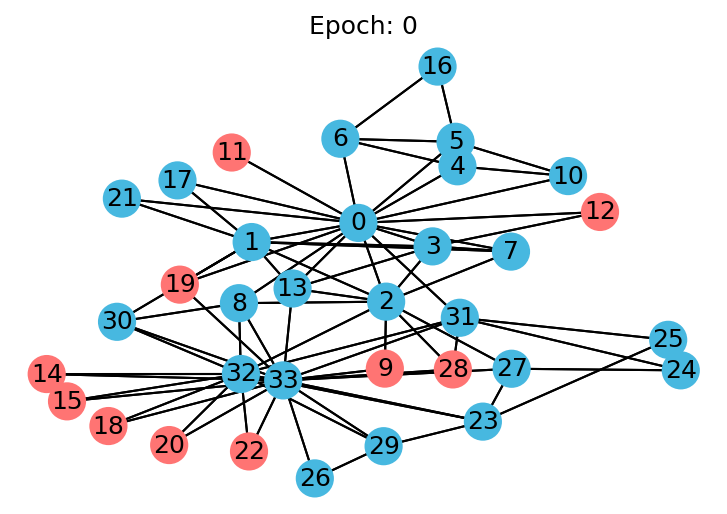

In [10]:
from IPython.display import HTML
def draw(i):
    colors = []
    for v in range(34):
        cls = logits_list[i][v].numpy().argmax()
        colors.append('#47B8E0' if cls else '#FF7473')
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G, pos, node_color=colors, arrows=False, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, draw, frames=len(logits_list), interval=200)
HTML(ani.to_html5_video())